In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
USE=True
# Set the impact category to be used
if USE:
    folder = "Resources"
    impact_score = "Abiotic Depletion [kgSb-eq/kWh]"
    cumulative_impact = "Abiotic Depletion [kgSb-eq]"
    threshold_c = "Concern Threshold [kgSb-eq/kWh]"
    threshold_i = "Indifference Threshold [kgSb-eq/kWh]"
    unit= "kgSb-eq/kWh"
else:
    folder = "ClimateChange"
    impact_score = "Climate Change [kgCO$_2$-eq/kWh]"
    cumulative_impact = "Climate Change [kgCO$_2$-eq]"
    threshold_c = "Concern Threshold [kgCO$_2$-eq/kWh]"
    threshold_i = "Indifference Threshold [kgCO$_2$-eq/kWh]"
    unit= "kgCO$_2$-eq/kWh"

Load the data for a run combining 10 threshold of concern with 10 thresholds of indifference

In [2]:
# Load the data
results_df = pd.read_csv(f"results/{folder}/batch_fixed_seed.csv")

In [3]:
# Select the columns
df = results_df[['Year', 'RunId', 'seed', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback', 
                 'Impact count', 'Total product', "Effect", "eol - new sold weight", "eol - used sold weight", 'eol - new recycled weight',
                   'eol - used recycled weight', 'eol - new landfilled weight', 'eol - used landfilled weight' ]].copy()

# Calculate Yearly electricity production and Impact
df.loc[:, 'Yearly electricity production'] = df.loc[:, 'Total product'] * 1.825  # conversion from Wp to kWh/year considering 5 hours of peak sun per day
df.loc[:, 'Impact'] = df.loc[:, 'Yearly electricity production'] * df.loc[:, 'Impact count']

# Calculate the total end-of-life paths
df['EoL - sold'] = df['eol - new sold weight'] + df['eol - used sold weight']
df['EoL - recycled'] = df['eol - new recycled weight'] + df['eol - used recycled weight']
df['EoL - landfilled'] = df['eol - new landfilled weight'] + df['eol - used landfilled weight']


total_end_of_life = df['EoL - sold'] + df['EoL - recycled'] + df['EoL - landfilled']

# Avoid division by zero by replacing zero totals with NaN
total_end_of_life = total_end_of_life.replace(0, float('nan'))

# Calculate the percentages
df.loc[:, 'EoL - sold'] = 100 * df.loc[:, 'EoL - sold'] / total_end_of_life
df.loc[:, 'EoL - recycled'] = 100 * df.loc[:, 'EoL - recycled'] / total_end_of_life
df.loc[:, 'EoL - circular pathways'] = df.loc[:, 'EoL - sold'] + df.loc[:, 'EoL - recycled']
df.loc[:, 'EoL - landfilled'] = 100 * df.loc[:, 'EoL - landfilled'] / total_end_of_life

df = df.fillna(0)

# Aggregate the data to model level
results_df_agg = df.groupby(['RunId', 'Year', 'seed']).agg({
    'threshold_concern': 'first',
    'threshold_indifference': 'first',
    'negative_feedback': 'first',
    'positive_feedback': 'first',
    'Impact count': 'first',
    'Impact': 'first',
    'Total product': 'first',
    'EoL - circular pathways': 'first',
    'EoL - landfilled': 'first',
    'Effect': 'first'
}).reset_index()

# Calculate cumulative impact per year
results_df_agg['Cumulative impact'] = results_df_agg.groupby(['Year', 'RunId', 'seed', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback'])['Impact'].cumsum()

results_df_agg.head(100)

,RunId,Year,seed,threshold_concern,threshold_indifference,negative_feedback,positive_feedback,Impact count,Impact,Total product,EoL - circular pathways,EoL - landfilled,Effect,Cumulative impact
0,0,2020,1,0.000024,0.000011,-0.5,1,0.000022,1.620235e+06,4.092100e+10,0.000000,0.000000,0.0,1.620235e+06
1,0,2021,1,0.000024,0.000011,-0.5,1,0.000022,1.889194e+06,4.771389e+10,0.425489,99.574511,0.0,1.889194e+06
2,0,2022,1,0.000024,0.000011,-0.5,1,0.000023,2.370382e+06,5.563439e+10,0.223285,99.776715,0.0,2.370382e+06
3,0,2023,1,0.000024,0.000011,-0.5,1,0.000023,2.767522e+06,6.486970e+10,0.159762,99.840238,0.0,2.767522e+06
4,0,2024,1,0.000024,0.000011,-0.5,1,0.000023,3.228271e+06,7.563807e+10,0.130958,99.869042,0.0,3.228271e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3,2022,1,0.000024,0.000013,-0.5,1,0.000023,2.370382e+06,5.563439e+10,0.223285,99.776715,0.0,2.370382e+06
96,3,2023,1,0.000024,0.000013,-0.5,1,0.000023,2.767522e+06,6.486970e+10,0.159762,99.840238,0.0,2.767522e+06
97,3,2024,1,0.000024,0.000013,-0.5,1,0.000023,3.228271e+06,7.563807e+10,0.130958,99.869042,0.0,3.228271e+06
98,3,2025,1,0.000024,0.000013,-0.5,1,0.000023,3.764873e+06,8.819399e+10,0.115944,99.884056,0.0,3.764873e+06


Variation of the threshold of concern: fix the threshold of indifference to the min (no threshold) and plot the results for the threshold of concern.

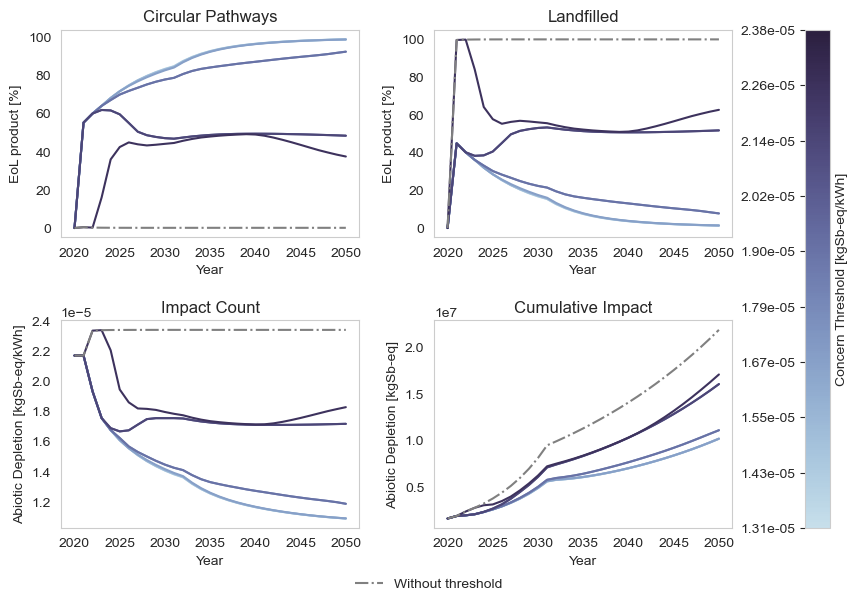

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the color palette
color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
indifference_threshold = results_df_agg["threshold_indifference"].min()

sns.set_style("whitegrid")

# Filter the DataFrame
filtered_df = results_df_agg[(results_df_agg["threshold_indifference"] == indifference_threshold) 
                             & (results_df_agg["seed"] == 1) 
                             & (results_df_agg['threshold_concern'] > 1* indifference_threshold)]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot configurations
plot_configs = [
    {"y": "EoL - circular pathways", "ylabel": "EoL product [%]", "title": "Circular Pathways", "ax": axs[0, 0]},
    {"y": "EoL - landfilled", "ylabel": "EoL product [%]", "title": "Landfilled", "ax": axs[0, 1]},
    {"y": "Cumulative impact", "ylabel": cumulative_impact, "xlabel": "Year", "title": "Cumulative Impact", "ax": axs[1, 1]},
    {"y": "Impact count", "ylabel": impact_score, "xlabel": "Year", "title": "Impact Count", "ax": axs[1, 0]},
]

# Create line plots
for config in plot_configs:
    g = sns.lineplot(
        data=filtered_df,
        x="Year",
        y=config["y"],
        hue="threshold_concern",
        palette=color_palette,
        ax=config["ax"],
        legend=False,
    )
    g.set(ylabel=config["ylabel"], title=config["title"])
    if "xlabel" in config:
        g.set(xlabel=config["xlabel"])

# Remove grid
for ax in axs.flat:
    ax.grid(False)

# Add space between the 2 rows of subplots
plt.subplots_adjust(top=0.95, bottom=0.12, right=0.999, left=0.1, hspace=0.4, wspace=0.25)


# For max concern threshold, color = grey
for ax in axs.flat:
    ax.lines[-1].set_linestyle("-.")
    ax.lines[-1].set_linewidth(1.5)
    ax.lines[-1].set_color("grey")

# Create a single color bar for all subplots
unique_thresholds = np.sort(filtered_df['threshold_concern'].unique())
norm = plt.Normalize(unique_thresholds.min(), unique_thresholds.max())
sm = plt.cm.ScalarMappable(cmap=color_palette, norm=norm)
sm.set_array([])

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.08, pad=0.09)
cbar.set_label(threshold_c)

# Set the ticks to the unique values of 'threshold_concern'
cbar.set_ticks(unique_thresholds)
cbar.ax.yaxis.tick_left()
cbar.set_ticklabels([f'{val:.2e}' for val in unique_thresholds])

# Add grey line for linear coupling
custom_lines_1 = [Line2D([0], [0], color='grey', linestyle='-.', lw=1.5, label='Without threshold')]
fig.legend(handles=custom_lines_1, loc='lower center', fontsize=10, frameon=False)


# save the plot high quality
plt.savefig(f"results/{folder}/lineplotconcern.png", dpi=300)

Adding the threshold of indifference: fix the threshold of concern and plot the results for the variation of the threshold of indifference.

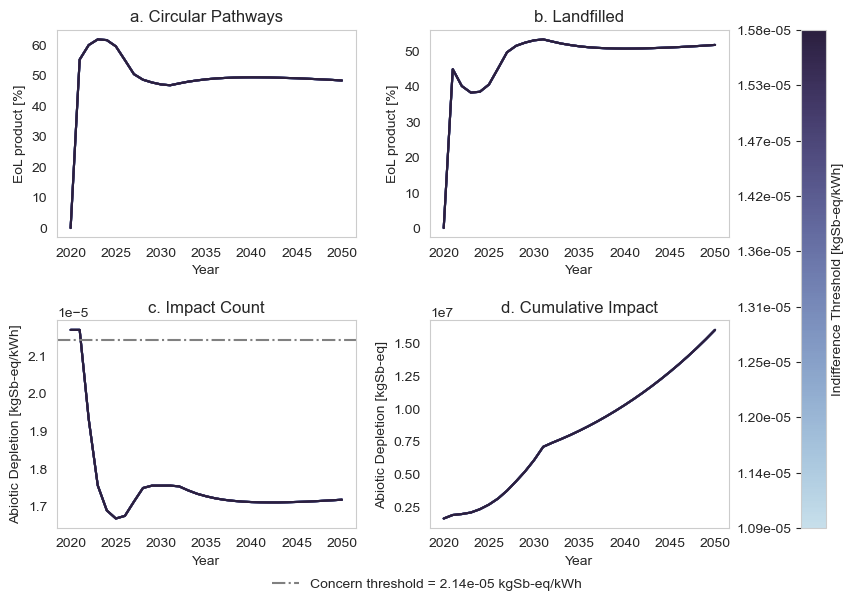

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set the concern threshold
unique_thresholds1 = np.sort(results_df_agg['threshold_concern'].unique())
concern_threshold = unique_thresholds1[7]  ### Change the index to select the concern threshold

# Filter the DataFrame
filtered_df = results_df_agg[(results_df_agg["seed"] == 1) & (results_df_agg["threshold_concern"] == concern_threshold) & (results_df_agg["threshold_indifference"] < 0.9*concern_threshold)]

# Define the color palette
color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.set_style("whitegrid")
# linecolors = [color_palette(i / (len(unique_thresholds) - 1)) for i in range(len(unique_thresholds))]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot configurations
plot_configs = [
    {"y": "EoL - circular pathways", "ylabel": "EoL product [%]", "title": "a. Circular Pathways", "ax": axs[0, 0]},
    {"y": "EoL - landfilled", "ylabel": "EoL product [%]", "title": "b. Landfilled", "ax": axs[0, 1]},
    {"y": "Cumulative impact", "ylabel": cumulative_impact, "xlabel": "Year", "title": "d. Cumulative Impact", "ax": axs[1, 1]},
    {"y": "Impact count", "ylabel": impact_score, "xlabel": "Year", "title": "c. Impact Count", "ax": axs[1, 0]},
]

# Create line plots
for config in plot_configs:
    g = sns.lineplot(
        data=filtered_df,
        x="Year",
        y=config["y"],
        hue="threshold_indifference",
        palette=color_palette,
        ax=config["ax"],
        legend=False
    )
    g.set(ylabel=config["ylabel"], title=config["title"])
    if "xlabel" in config:
        g.set(xlabel=config["xlabel"])

# Remove grid
for ax in axs.flat:
    ax.grid(False)

# Add an horizontal for the concern threshold in the lower right subplot
axs[1, 0].axhline(y=concern_threshold, color='grey', linestyle='-.', linewidth=1.5)

# Add space between the 2 rows of subplots
plt.subplots_adjust(top=0.95, bottom=0.12, right=0.999, left=0.1, hspace=0.4, wspace=0.25)

# Create a single color bar for all subplots
unique_thresholds = np.sort(filtered_df['threshold_indifference'].unique())
norm = plt.Normalize(unique_thresholds.min(), unique_thresholds.max())
sm = plt.cm.ScalarMappable(cmap=color_palette, norm=norm)
sm.set_array([])

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.08, pad=0.09)
cbar.set_label(threshold_i)

# Set the ticks to the unique values of 'threshold_concern'
cbar.set_ticks(unique_thresholds)
cbar.ax.yaxis.tick_left()
cbar.set_ticklabels([f'{val:.2e}' for val in unique_thresholds])

# Add grey line for linear coupling
custom_lines_1 = [Line2D([0], [0], color='grey', linestyle='-.', lw=1.5, label=f'Concern threshold = {concern_threshold:.2e} {unit}')]
fig.legend(handles=custom_lines_1, loc='lower center', fontsize=10, frameon=False)

# save the plot high quality
plt.savefig(f"results/{folder}/lineplotindifference/{concern_threshold}.png", dpi=300)

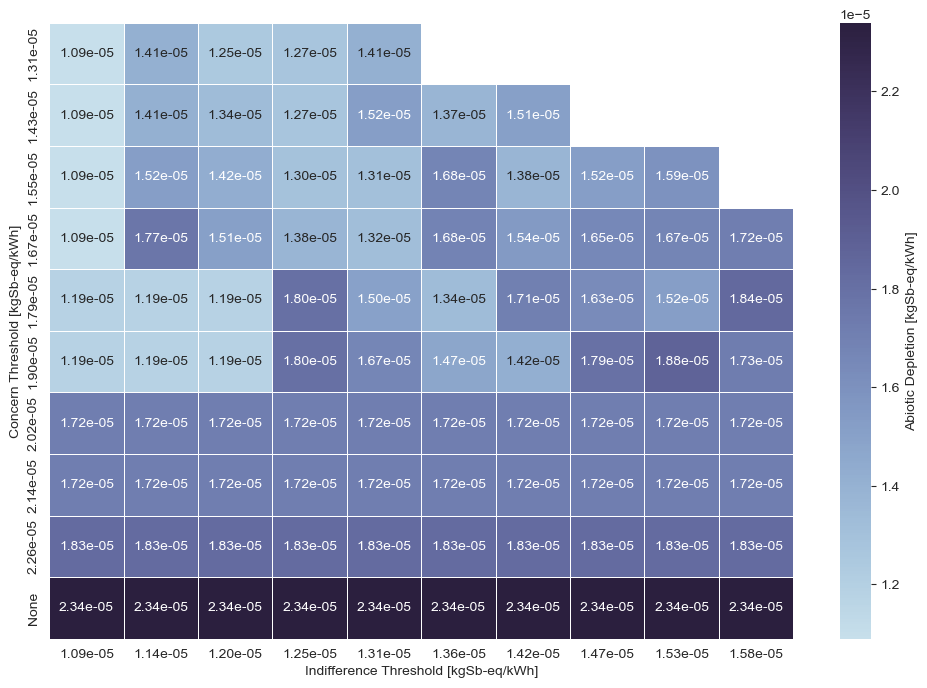

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the concern and indifference thresholds
unique_thresholds_concern = np.sort(results_df_agg['threshold_concern'].unique())
unique_thresholds_indifference = np.sort(results_df_agg['threshold_indifference'].unique())
max_threshold_concern = unique_thresholds_concern[-1]

# Filter the DataFrame for the year 2050
filtered_df = results_df_agg[(results_df_agg["Year"] == 2050)]

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = filtered_df.pivot_table(
    index='threshold_concern',
    columns='threshold_indifference',
    values='Impact count',
)

# Block out results where threshold of indifference > threshold of concern
for ind in heatmap_data.index:
    for col in heatmap_data.columns:
        if ind < col:
            heatmap_data.at[ind, col] = np.nan

# Define the color palette
color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.set_style("whitegrid")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap=color_palette,
    annot=True,
    fmt=".2e",
    linewidths=.5,
    cbar_kws={'label': impact_score},
    xticklabels=[f'{val:.2e}' for val in heatmap_data.columns],
    yticklabels=[f'{val:.2e}' if val != max_threshold_concern else 'None' for val in heatmap_data.index]
)

# Add labels and title
plt.xlabel(threshold_i)
plt.ylabel(threshold_c)
plt.grid(False)

# Save the plot in high quality
plt.savefig(f"results/{folder}/heatmap_impact_2050.png", dpi=300)

# Show the plot
plt.show()

Load data for 100 seeds and each threshold: using shaded area to represent the the 25th, 50th (median), and 75th percentiles..

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Initialize an empty DataFrame
results_df = pd.DataFrame()

# Loop to load data based on the concern threshold
for n in range(10):
    # Load the CSV file
    df = pd.read_csv(f"results/{folder}/batch_seed_results{n}.csv")
    
    # Add a RunId column
    df['RunId'] = n

    # Select the columns
    df = df[['Year', 'RunId', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback', 
             'Impact count', 'Total product', "Effect", "eol - new sold weight", "eol - used sold weight", 'eol - new recycled weight',
             'eol - used recycled weight', 'eol - new landfilled weight', 'eol - used landfilled weight']].copy()

    # Calculate Yearly electricity production and Impact
    df['Yearly electricity production'] = df['Total product'] * 1.825  # conversion from Wp to kWh/year considering 5 hours of peak sun per day
    df['Impact'] = df['Yearly electricity production'] * df['Impact count']

    # Calculate the total end-of-life paths
    df['EoL - sold'] = df['eol - new sold weight'] + df['eol - used sold weight']
    df['EoL - recycled'] = df['eol - new recycled weight'] + df['eol - used recycled weight']
    df['EoL - landfilled'] = df['eol - new landfilled weight'] + df['eol - used landfilled weight']

    total_end_of_life = df['EoL - sold'] + df['EoL - recycled'] + df['EoL - landfilled']

    # Avoid division by zero by replacing zero totals with NaN
    total_end_of_life = total_end_of_life.replace(0, float('nan'))

    # Calculate the percentages
    df['EoL - sold'] = 100 * df['EoL - sold'] / total_end_of_life
    df['EoL - recycled'] = 100 * df['EoL - recycled'] / total_end_of_life
    df['EoL - circular pathways'] = df['EoL - sold'] + df['EoL - recycled']
    df['EoL - landfilled'] = 100 * df['EoL - landfilled'] / total_end_of_life

    df = df.fillna(0)

    # Aggregate the data to model level using quantiles
    df_agg = df.groupby(['RunId', 'Year', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback']).agg({
        'Effect': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
        'Total product': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
        'EoL - circular pathways': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
        'EoL - landfilled': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
        'Impact': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
        'Impact count': [lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)],
    }).reset_index()

    # Flatten the MultiIndex columns
    df_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_agg.columns.values]

    # Calculate cumulative impact per year for different quantiles
    df_agg['Cumulative impact_quantile_25'] = df_agg.groupby(['RunId', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback'])['Impact_<lambda_0>'].cumsum()
    df_agg['Cumulative impact_quantile_50'] = df_agg.groupby(['RunId', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback'])['Impact_<lambda_1>'].cumsum()
    df_agg['Cumulative impact_quantile_75'] = df_agg.groupby(['RunId', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback'])['Impact_<lambda_2>'].cumsum()

    # Concatenate the DataFrame to the results_df
    results_df = pd.concat([results_df, df_agg], ignore_index=True)

# Display the first 100 rows of the results DataFrame
results_df.head(100)

,RunId,Year,threshold_concern,threshold_indifference,negative_feedback,positive_feedback,Effect_<lambda_0>,Effect_<lambda_1>,Effect_<lambda_2>,Total product_<lambda_0>,...,EoL - landfilled_<lambda_2>,Impact_<lambda_0>,Impact_<lambda_1>,Impact_<lambda_2>,Impact count_<lambda_0>,Impact count_<lambda_1>,Impact count_<lambda_2>,Cumulative impact_quantile_25,Cumulative impact_quantile_50,Cumulative impact_quantile_75
0,0,2020,0.000024,0,-0.5,1,0.0,0.0,0.0,4.092100e+10,...,0.000000,1.620235e+06,1.620235e+06,1.620235e+06,0.000022,0.000022,0.000022,1.620235e+06,1.620235e+06,1.620235e+06
1,0,2021,0.000024,0,-0.5,1,0.0,0.0,0.0,4.771389e+10,...,99.845037,1.889194e+06,1.889194e+06,1.889194e+06,0.000022,0.000022,0.000022,3.509430e+06,3.509430e+06,3.509430e+06
2,0,2022,0.000024,0,-0.5,1,0.0,0.0,0.0,5.563439e+10,...,99.897261,2.370235e+06,2.372632e+06,2.374584e+06,0.000023,0.000023,0.000023,5.879664e+06,5.882062e+06,5.884014e+06
3,0,2023,0.000024,0,-0.5,1,0.0,0.0,0.0,6.486970e+10,...,99.917493,2.765469e+06,2.767519e+06,2.769710e+06,0.000023,0.000023,0.000023,8.645134e+06,8.649582e+06,8.653723e+06
4,0,2024,0.000024,0,-0.5,1,0.0,0.0,0.0,7.563807e+10,...,99.931614,3.224582e+06,3.227732e+06,3.229950e+06,0.000023,0.000023,0.000023,1.186972e+07,1.187731e+07,1.188367e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3,2022,0.000020,0,-0.5,1,0.0,0.0,0.0,5.563439e+10,...,40.258384,1.955371e+06,1.962052e+06,1.969036e+06,0.000019,0.000019,0.000019,5.464801e+06,5.471482e+06,5.478465e+06
96,3,2023,0.000020,0,-0.5,1,0.0,0.0,0.0,6.486970e+10,...,37.805173,2.060327e+06,2.072216e+06,2.086804e+06,0.000017,0.000018,0.000018,7.525128e+06,7.543698e+06,7.565270e+06
97,3,2024,0.000020,0,-0.5,1,0.0,0.0,0.0,7.563807e+10,...,37.159991,2.300222e+06,2.317286e+06,2.338918e+06,0.000017,0.000017,0.000017,9.825350e+06,9.860984e+06,9.904187e+06
98,3,2025,0.000020,0,-0.5,1,0.0,0.0,0.0,8.819399e+10,...,37.981166,2.598334e+06,2.631366e+06,2.664597e+06,0.000016,0.000016,0.000017,1.242368e+07,1.249235e+07,1.256878e+07


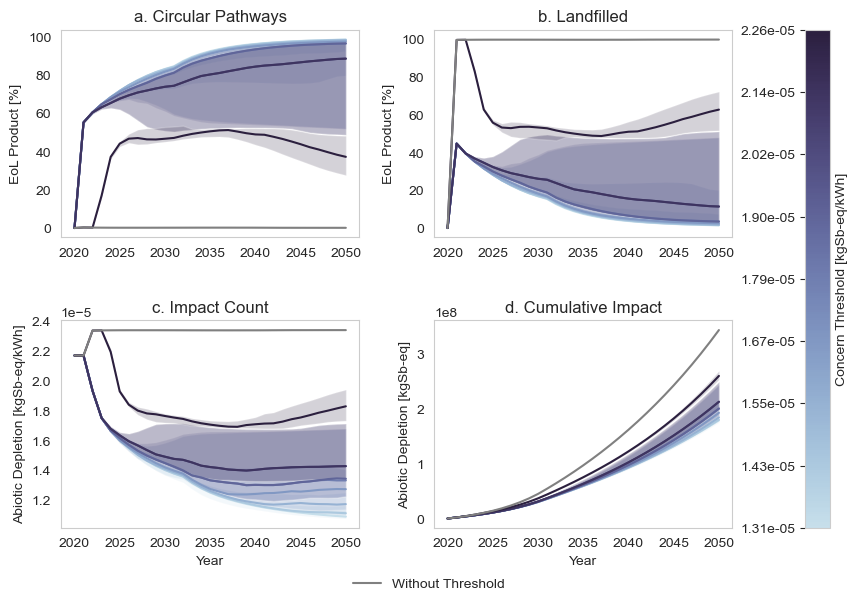

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the color palette
color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

# Set the plot style
sns.set_style("whitegrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot configurations
plot_configs = [
    {"y": "EoL - circular pathways_<lambda_1>", "y_25": "EoL - circular pathways_<lambda_0>", "y_75": "EoL - circular pathways_<lambda_2>", "ylabel": "EoL Product [%]", "title": "a. Circular Pathways", "ax": axs[0, 0]},
    {"y": "EoL - landfilled_<lambda_1>", "y_25": "EoL - landfilled_<lambda_0>", "y_75": "EoL - landfilled_<lambda_2>", "ylabel": "EoL Product [%]", "title": "b. Landfilled", "ax": axs[0, 1]},
    {"y": "Cumulative impact_quantile_50", "y_25": "Cumulative impact_quantile_25", "y_75": "Cumulative impact_quantile_75","ylabel": cumulative_impact, "xlabel": "Year", "title": "d. Cumulative Impact", "ax": axs[1, 1]},
    {"y": "Impact count_<lambda_1>", "y_25": "Impact count_<lambda_0>", "y_75": "Impact count_<lambda_2>", "ylabel": impact_score, "xlabel": "Year", "title": "c. Impact Count", "ax": axs[1, 0]},
]

# Identify thresholds that produce unique results
unique_thresholds = (
    results_df.groupby("threshold_concern")
    .apply(lambda x: x.mean().tolist())  # Get mean results for each threshold
    .drop_duplicates()  # Retain only distinct results
    .reset_index()["threshold_concern"]  # Extract corresponding thresholds
)

# Normalize for the color mapping
unique_thresholds = unique_thresholds.sort_values()
unique_thresholds_1 = unique_thresholds[:-1]
norm = plt.Normalize(min(unique_thresholds), max(unique_thresholds_1))

# Filter DataFrame to include only unique thresholds
filtered_df = results_df[results_df["threshold_concern"].isin(unique_thresholds)]

# Create line plots with shaded areas for the 25th and 75th percentiles
for i, config in enumerate(plot_configs):
    for key, grp in filtered_df.groupby("threshold_concern"):
        ax = config["ax"]
        x = grp["Year"]
        y = grp[config["y"]]

        # Set color based on threshold value
        color = "grey" if key == unique_thresholds.max() else color_palette(norm(key))

        ax.plot(x, y, label=f"Threshold {key:.3f}", color=color)

        # Add shaded area for the 25th and 75th percentiles if applicable
        if "y_25" in config and "y_75" in config:
            y_25 = grp[config["y_25"]]
            y_75 = grp[config["y_75"]]
            ax.fill_between(x, y_25, y_75, color=color, alpha=0.2, edgecolor=None)

        ax.set(ylabel=config["ylabel"], title=config["title"])
        if "xlabel" in config:
            ax.set(xlabel=config["xlabel"])

# Disable grid for clarity
for ax in axs.flat:
    ax.grid(False)

# Adjust spacing between subplots
plt.subplots_adjust(top=0.95, bottom=0.12, right=0.999, left=0.1, hspace=0.4, wspace=0.25)

# Create a single color bar for the thresholds
sm = plt.cm.ScalarMappable(cmap=color_palette, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation="vertical", fraction=0.08, pad=0.09)
cbar.set_label(threshold_c)
cbar.set_ticks(unique_thresholds_1)
cbar.ax.yaxis.tick_left()
cbar.set_ticklabels([f"{val:.2e}" for val in unique_thresholds_1])

# Add grey line legend for the maximum threshold
custom_lines = [Line2D([0], [0], color="grey", linestyle="-", lw=1.5, label="Without Threshold")]
fig.legend(handles=custom_lines, loc="lower center", fontsize=10, frameon=False)

# Save the plot
plt.savefig(f"results/{folder}/lineplotconcern_%.png", dpi=300)

# Show the plot
plt.show()


Figure for graphical abstract

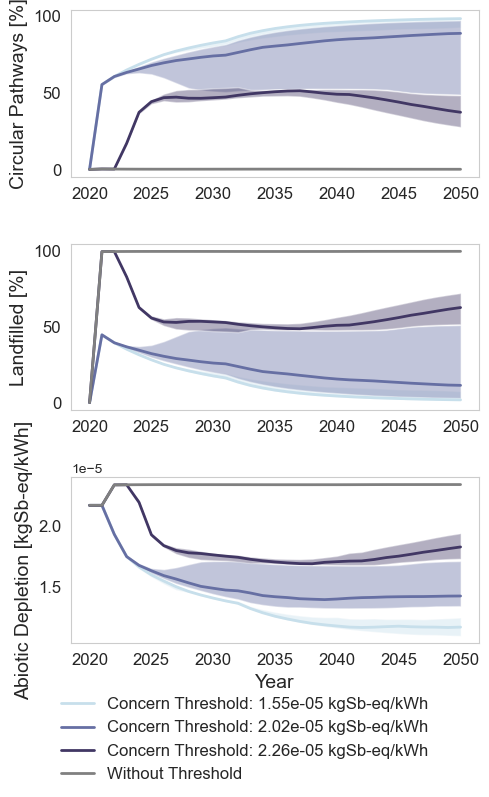

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the color palette
color_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

sns.set_style("whitegrid")

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

# Plot configurations
plot_configs = [
    {"y": "EoL - circular pathways_<lambda_1>", "y_25": "EoL - circular pathways_<lambda_0>", "y_75": "EoL - circular pathways_<lambda_2>", "ylabel": "Circular Pathways [%]", "ax": axs[0]},
    {"y": "EoL - landfilled_<lambda_1>", "y_25": "EoL - landfilled_<lambda_0>", "y_75": "EoL - landfilled_<lambda_2>", "ylabel":"Landfilled [%]", "ax": axs[1]},
    {"y": "Impact count_<lambda_1>", "y_25": "Impact count_<lambda_0>", "y_75": "Impact count_<lambda_2>", "xlabel": "Year", "ylabel": impact_score, "ax": axs[2]}
]

# Normalize the threshold values
thresholds = np.sort(results_df['threshold_concern'].unique())
unique_thresholds = thresholds[[2 ,6, 8, 9]]
norm = plt.Normalize(unique_thresholds.min(), unique_thresholds.max())

# Create line plots with shaded areas for standard deviation
for config in plot_configs:
    for key, grp in results_df[results_df["threshold_concern"].isin(unique_thresholds)].groupby('threshold_concern'):
        ax = config["ax"]
        x = grp['Year']
        y = grp[config["y"]]
        
        # Set color based on whether the threshold is the maximum
        if key == unique_thresholds.max():
            color = "grey"
        else:
            color = color_palette(norm(key))
        
        ax.plot(x, y, label=f'Threshold {key:.2e}', color=color, linewidth=2)
        if "y_25" in config and "y_75" in config:
            y_25 = grp[config["y_25"]]
            y_75 = grp[config["y_75"]]
            ax.fill_between(x, y_25, y_75, color=color, alpha=0.4, edgecolor=None)
        
        ax.set(ylabel=config["ylabel"])
        if "xlabel" in config:
            ax.set(xlabel=config["xlabel"])

# Remove grid
for ax in axs.flat:
    ax.grid(False)

# Increase font sizes for better visibility
for ax in axs.flat:
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout with tight_layout and specified hspace and wspace
fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.25, bottom=0.19)

# Create custom legend entries for each threshold
legend_elements = [Line2D([0], [0], color=color_palette(norm(threshold)), lw=2, label=f'Concern Threshold: {threshold:.2e} {unit}')
                   for threshold in unique_thresholds if threshold != unique_thresholds.max()]
legend_elements.append(Line2D([0], [0], color='grey', lw=2, label='Without Threshold'))

# Add the custom legend to the figure
fig.legend(handles=legend_elements, loc='lower center', fontsize=12, frameon=False, ncol=1)

# Save the plot
plt.savefig(f"results/{folder}/graphical_abstract.png", dpi=300)

# Show the plot
plt.show()

Figures of the results for each threshold for year 2025, 2030, 2035, 2040, 2045 and 2050 (100 runs)

In [9]:

# Initialize empty DataFrames for each year
results_df_year_25 = pd.DataFrame()
results_df_year_30 = pd.DataFrame()
results_df_year_35 = pd.DataFrame()
results_df_year_40 = pd.DataFrame()
results_df_year_45 = pd.DataFrame()
results_df_year_50 = pd.DataFrame()


# Loop to load data based on the concern threshold
for n in range(10):
    # Load the CSV file
    df = pd.read_csv(f"results/{folder}/batch_seed_results{n}.csv")
    
    # Add a RunId column
    df['RunId'] = n

    # Select the columns
    df = df[['Year', 'RunId', 'seed', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback', 
             'Impact count', 'Total product', "Effect", "eol - new sold weight", "eol - used sold weight", 'eol - new recycled weight',
             'eol - used recycled weight', 'eol - new landfilled weight', 'eol - used landfilled weight']].copy()

    # Calculate Yearly electricity production and Impact
    df['Yearly electricity production'] = df['Total product'] * 1.825  # conversion from Wp to kWh/year considering 5 hours of peak sun per day
    df['Impact'] = df['Yearly electricity production'] * df['Impact count']

    # Calculate the total end-of-life paths
    df['EoL - sold'] = df['eol - new sold weight'] + df['eol - used sold weight']
    df['EoL - recycled'] = df['eol - new recycled weight'] + df['eol - used recycled weight']
    df['EoL - landfilled'] = df['eol - new landfilled weight'] + df['eol - used landfilled weight']

    total_end_of_life = df['EoL - sold'] + df['EoL - recycled'] + df['EoL - landfilled']

    # Avoid division by zero by replacing zero totals with NaN
    total_end_of_life = total_end_of_life.replace(0, float('nan'))

    # Calculate the percentages
    df['EoL - sold'] = 100 * df['EoL - sold'] / total_end_of_life
    df['EoL - recycled'] = 100 * df['EoL - recycled'] / total_end_of_life
    df['EoL - circular pathways'] = df['EoL - sold'] + df['EoL - recycled']
    df['EoL - landfilled'] = 100 * df['EoL - landfilled'] / total_end_of_life

    df = df.fillna(0)

    # Aggregate the data to model level
    df_agg = df.groupby(['RunId', 'Year', 'seed']).agg({
        'threshold_concern': 'first',
        'threshold_indifference': 'first',
        'negative_feedback': 'first',
        'positive_feedback': 'first',
        'Impact count': 'first',
        'Impact': 'first',
        'Total product': 'first',
        'EoL - circular pathways': 'first',
        'EoL - landfilled': 'first',
        'Effect': 'first'}).reset_index()
    
    # Calculate cumulative impact per year
    df_agg['Cumulative impact'] = df_agg.groupby(['Year', 'RunId', 'seed', 'threshold_concern', 'threshold_indifference', 'negative_feedback', 'positive_feedback'])['Impact'].cumsum()

    # Concatenate the DataFrame to the corresponding results DataFrame
    results_df_year_25 = pd.concat([results_df_year_25, df_agg[df_agg['Year'] == 2025]], ignore_index=True)
    results_df_year_30 = pd.concat([results_df_year_30, df_agg[df_agg['Year'] == 2030]], ignore_index=True)
    results_df_year_35 = pd.concat([results_df_year_35, df_agg[df_agg['Year'] == 2035]], ignore_index=True)
    results_df_year_40 = pd.concat([results_df_year_40, df_agg[df_agg['Year'] == 2040]], ignore_index=True)
    results_df_year_45 = pd.concat([results_df_year_45, df_agg[df_agg['Year'] == 2045]], ignore_index=True)
    results_df_year_50 = pd.concat([results_df_year_50, df_agg[df_agg['Year'] == 2050]], ignore_index=True)


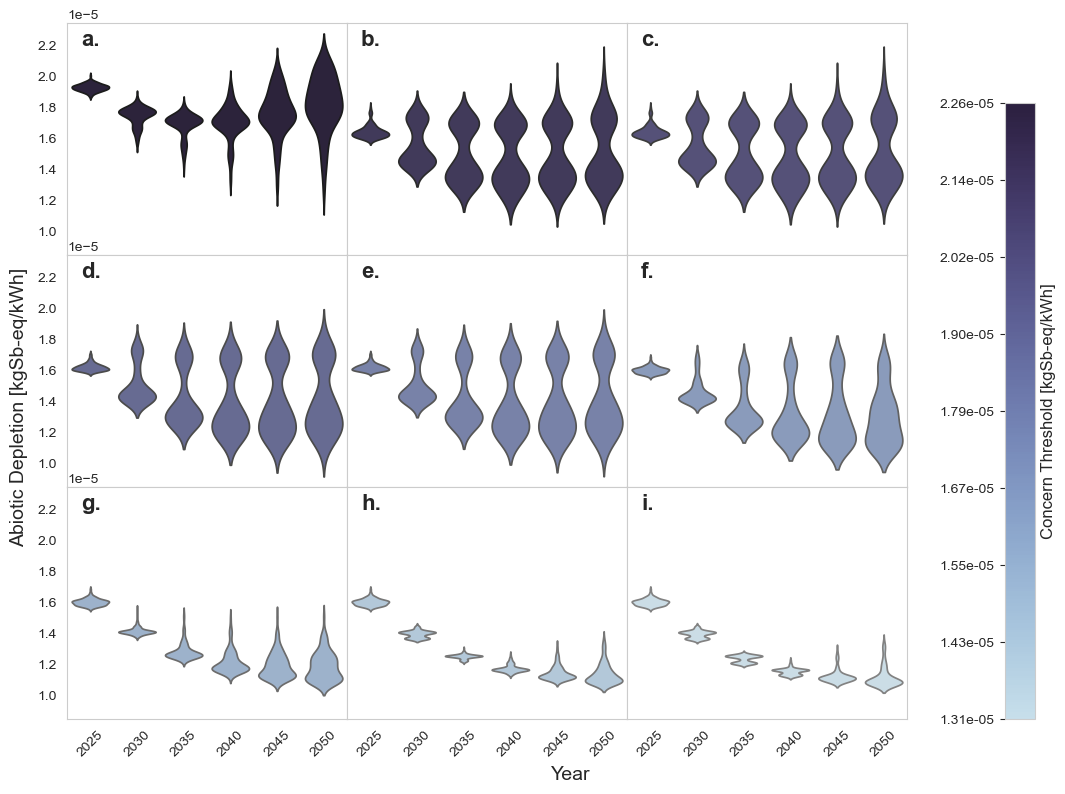

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the years to plot
years = [2025, 2030, 2035, 2040, 2045, 2050]
results_dfs = [results_df_year_25, results_df_year_30, results_df_year_35, results_df_year_40, results_df_year_45, results_df_year_50]

# Set the plot style
sns.set_style("whitegrid")

# Get all unique thresholds from all dataframes, excluding the max threshold
all_thresholds = sorted(set(np.concatenate([df["threshold_concern"].unique() for df in results_dfs])), reverse=True)
all_thresholds.remove(max(all_thresholds))  # Remove the max threshold

# Create subplots (3 rows, 3 columns)
fig, axs = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

# Create a color map using the specified palette
color_map = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

# Loop through each threshold and create a violin plot for it
for i, threshold in enumerate(all_thresholds):
    # Collect data for this threshold across all years
    data = []
    for year, results_df_year in zip(years, results_dfs):
        results_df_filtered = results_df_year[results_df_year["threshold_concern"] == threshold]
        data.append(results_df_filtered["Impact count"].values)

    # Normalize the threshold for color mapping
    color_value = (threshold - min(all_thresholds)) / (max(all_thresholds) - min(all_thresholds))
    
    # Create the violin plot for this threshold
    sns.violinplot(
        data=data,
        ax=axs[i],
        palette=[color_map(color_value)],  # Use the color map for the current threshold
        inner=None  
    )
    
    # Explicitly set the x-ticks and their labels
    axs[i].set_xticks(range(len(years)))  # Set tick positions for each year
    axs[i].set_xticklabels(years, rotation=45)  # Set tick labels to the years and rotate them
    axs[i].grid(False)  # Remove the grid
    # Add subplot label (a, b, c, etc.)
    axs[i].text(0.05, 0.9, f'{chr(97 + i)}.', transform=axs[i].transAxes, size=16, weight='bold')

# Create a single color bar for all subplots
unique_thresholds = np.sort(all_thresholds)
norm = plt.Normalize(unique_thresholds.min(), unique_thresholds.max())  # Normalize the threshold values
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)  # Use the custom colormap
sm.set_array([])  # Empty array is required by ScalarMappable

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.05, pad=0)
cbar.set_label(threshold_c, fontsize=12)

# Set the ticks to the unique values of 'threshold_concern'
cbar.set_ticks(unique_thresholds)
cbar.ax.yaxis.tick_left()  # Move the ticks to the left side of the color bar
cbar.set_ticklabels([f'{val:.2e}' for val in unique_thresholds])  # Format tick labels

# Adjust the layout to remove the space between subplots
plt.subplots_adjust(hspace=0, wspace=0, right = 0.78, left = 0.08, top = 0.98)  # Remove horizontal and vertical space

# Add overall axis labels
fig.text(0.5, 0.04, 'Year', ha='center', va='center', fontsize=14)  # X-axis label
fig.text(0.04, 0.5, impact_score, ha='center', va='center', rotation='vertical', fontsize=14)  # Y-axis label

# Save the plot
plt.savefig(f"results/{folder}/violin_plots_year_axis.png", dpi=300)

# Show the plot
plt.show()


Closer look at the situation after 30 years: figures of the results for each threshold in 2050 (100 runs). High variability across runs

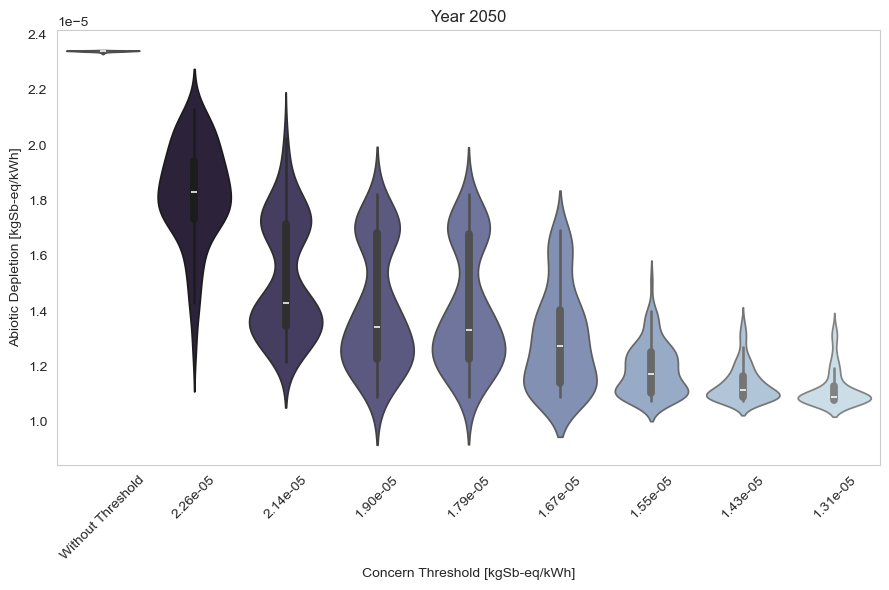

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming results_df_year_50 is already loaded and processed
# results_df_year_50 = pd.read_csv("path_to_your_results.csv")

# Identify the highest concern threshold
max_threshold = results_df_year_50["threshold_concern"].max()

# Exclude the maximum threshold from the results
results_df_filtered = results_df_year_50[results_df_year_50["threshold_concern"] != max_threshold]

sns.set_style("whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Variables for plotting
x_var = "threshold_concern"
y_var = "Impact count"

# Plot the violin plot for the highest concern threshold in grey
sns.violinplot(
    data=results_df_year_50[results_df_year_50["threshold_concern"] == max_threshold],
    x=x_var,
    y=y_var,
    color="grey",
    ax=ax
)

# Add labels and title
ax.set_xlabel(threshold_c)
ax.set_ylabel(impact_score)
ax.set_title("Year 2050")

# Collect significant thresholds by excluding those that produce duplicate results
significant_thresholds = (
    results_df_filtered.groupby("threshold_concern")[y_var]
    .apply(lambda x: x.mean())  # Use the mean to identify unique results
    .reset_index()
    .sort_values(by="threshold_concern", ascending=False)
    .drop_duplicates(subset=[y_var])  # Drop thresholds producing the same mean result
)["threshold_concern"].tolist()

# Define the color palette for the remaining significant thresholds
color_palette = sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(significant_thresholds))[::-1]

# Create violin plots for each remaining significant threshold
for i, threshold in enumerate(significant_thresholds):
    sns.violinplot(
        data=results_df_filtered[results_df_filtered["threshold_concern"] == threshold],
        x=x_var,
        y=y_var,
        color=color_palette[i],
        ax=ax
    )

# Customize x-axis labels to include "Without Threshold" for the maximum threshold
x_labels = [f'{label:.2e}' if label != max_threshold else 'Without Threshold' for label in [max_threshold] + significant_thresholds]

ax.xaxis.set_major_locator(FixedLocator(range(len(x_labels))))
ax.set_xticklabels(x_labels, rotation=45)

# Disable grid for better visualization
ax.grid(False)

plt.tight_layout()  

# Save the plot
plt.savefig(f"results/{folder}/violin_plot_2050.png", dpi=300)

# Show the plot
plt.show()
